In [70]:
import matplotlib.pyplot as plt
import os
import pandas as pd

from scipy.stats import f_oneway, anderson

import seaborn as sns


In [2]:
data_path = os.path.join("..", "data", "01_raw")

Is there any correlation between soil, CO2 and fertilizer with the yields?

In [9]:
train_solutions_wheat_df = pd.read_parquet(os.path.join(data_path, 'train_solutions_wheat.parquet'))
train_solutions_maize_df = pd.read_parquet(os.path.join(data_path, 'train_solutions_maize.parquet'))

In [10]:
soil_co2_wheat_train_df = pd.read_parquet(os.path.join(data_path, 'soil_co2_wheat_train.parquet'))
soil_co2_maize_train_df = pd.read_parquet(os.path.join(data_path, 'soil_co2_maize_train.parquet'))

In [11]:
wheat_joined_df = train_solutions_wheat_df.join(soil_co2_wheat_train_df) 
maize_joined_df = train_solutions_maize_df.join(soil_co2_maize_train_df) 

In [46]:
df_list = [wheat_joined_df, maize_joined_df] # add more DataFrames as needed
df_names = ['wheat', 'maize']

variables_list = ['yield', 'co2', 'nitrogen', 'real_year', 'lat', 'lon']

C:\Users\Z478SG\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 278747.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Z478SG\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 349719.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Z478SG\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 278747.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Z478SG\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 349719.
  res = hypotest_fun_out(*samples, **kwds)


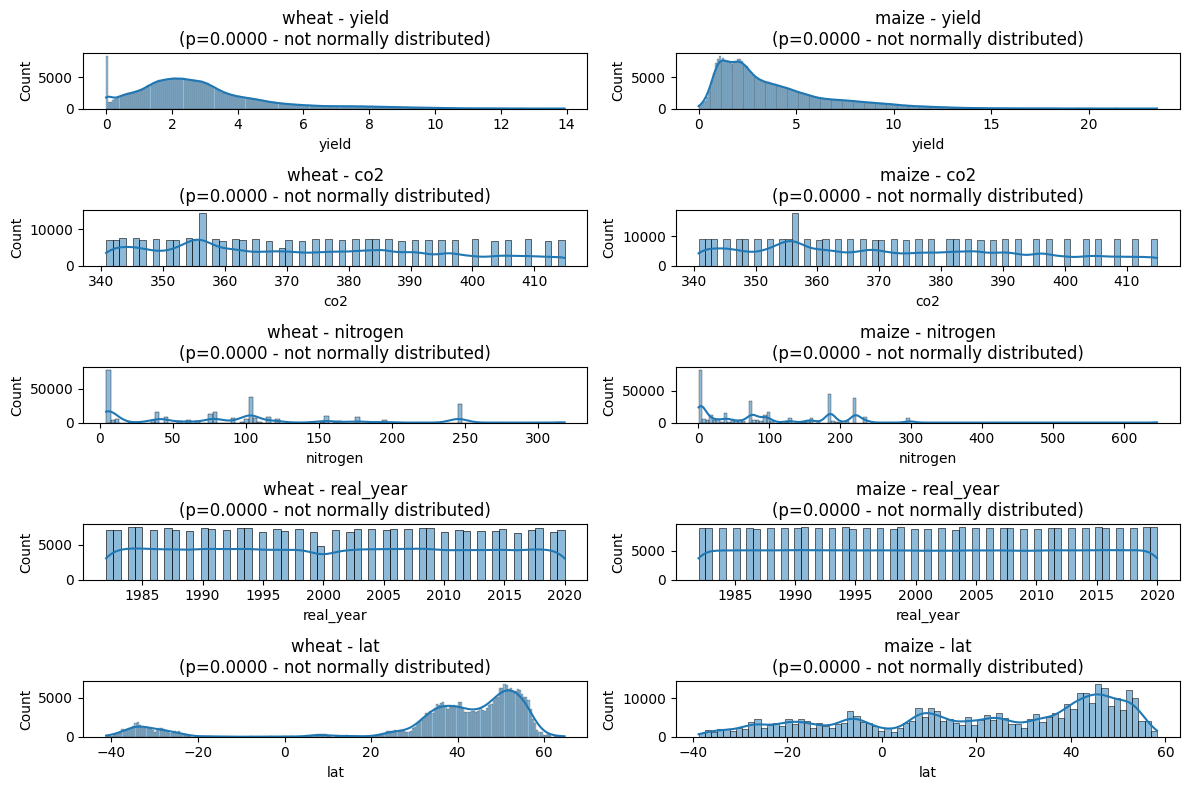

In [75]:
fig, axes = plt.subplots(nrows=len(variables_list), ncols=len(df_list), figsize=(12, 8))

for i, var in enumerate(variables_list):
    for j, df in enumerate(df_list):
        # We should use the Anderson test because N > 5000
        stat, p = shapiro(df[var])
        normality_status = "normally distributed" if p > 0.05 else "not normally distributed"
        title = f"{df_names[j]} - {var}\n(p={p:.4f} - {normality_status})"

        sns.histplot(df[var], kde=True, ax=axes[i, j])
        axes[i, j].set_title(title)

plt.tight_layout()
plt.show()


In [69]:
for i, df in enumerate(df_list):
    print(f"Observed values for each category for {df_names[i]}\n{df['texture_class'].value_counts()}")
    expected_values_count = int(len(df)/df['texture_class'].nunique())
    print(f"\nEach texture_class should have {expected_values_count} values")

Observed values for each category for wheat
texture_class
9.0     160216
7.0      42120
3.0      24176
5.0      13730
11.0     11415
12.0      7574
10.0      6079
2.0       5903
1.0       3534
13.0      2544
4.0       1456
Name: count, dtype: int64

Each texture_class should have 25340 values
Observed values for each category for maize
texture_class
9.0     141624
3.0      46142
10.0     40626
7.0      30980
11.0     28957
5.0      12656
12.0     12348
1.0      11172
13.0     10270
2.0       7879
8.0       4939
4.0       2126
Name: count, dtype: int64

Each texture_class should have 29143 values


Both texture_class variables are not evenly distributed. We should take that in consideration in the statistical tests

In [76]:
wheat_corr_matrix = wheat_joined_df[['yield', 'lon', 'lat', 'texture_class', 'real_year', 'co2', 'nitrogen']].corr(method="spearman") # We use spearman correlation method because all the variables are not normally distributed.
maize_corr_matrix = maize_joined_df[['yield', 'lon', 'lat', 'texture_class', 'real_year', 'co2', 'nitrogen']].corr(method="spearman") # We use spearman correlation method because all the variables are not normally distributed.

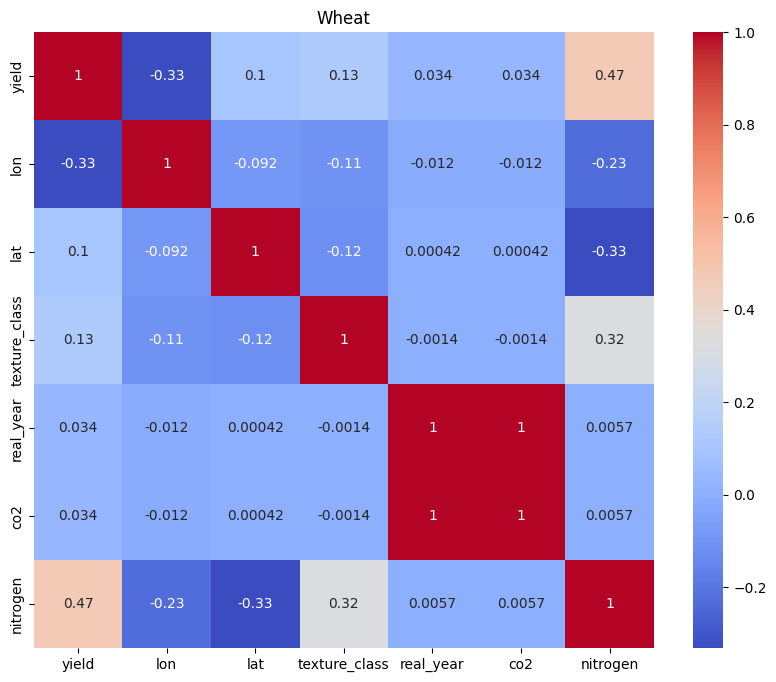

In [77]:
plt.figure(figsize=(10,8))
sns.heatmap(wheat_corr_matrix, annot=True, cmap='coolwarm')
plt.title("Wheat")
plt.show()

For wheat, yield is highly correlated with fertilization (r2=0.47), then a bit with the texture class as a numerical variable (r2=0.13).  
It is also correlated with the latitude and longitude (r2=0.1 and -0.33).  

It doesn't seem like it's correlated with the year or the level of CO2.  
However, CO2 level and real yearly are 100% correlated (r2=1). We should investigate this.

Soil texture is correlated with fertilization (r2=0.32). We should then be careful and be sure we want to use both variables in our model.
Fertilisation seems also correlated with longitude and latitude (r2=-0.23 and 0.33). We should check if this is not a random correlation

- We could also try to look for a correlation between texture_class as a categorical value not ordered.
- We could create another variable to group latitude and longitude and assess the correlation again.  

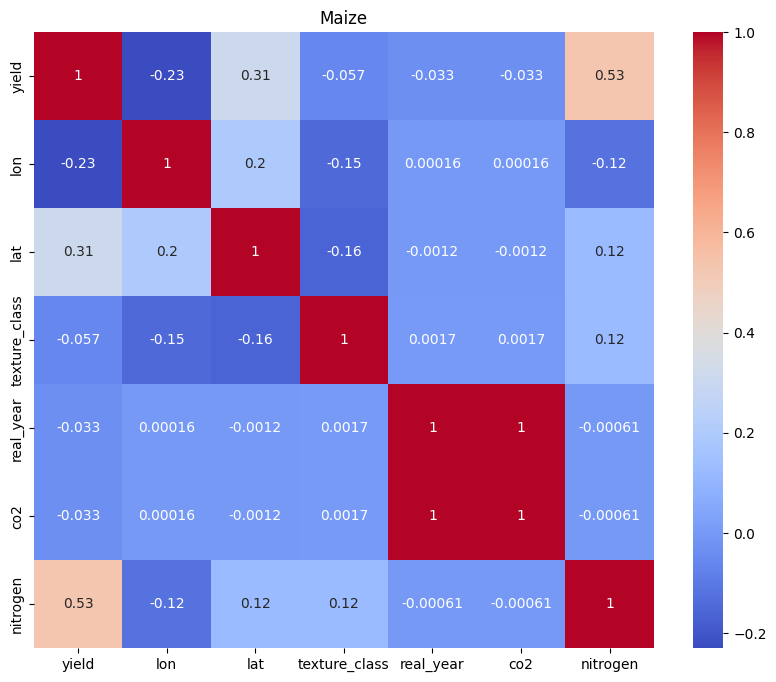

In [78]:
plt.figure(figsize=(10,8))
sns.heatmap(maize_corr_matrix, annot=True, cmap='coolwarm')
plt.title("Maize")
plt.show()

For maize, yield is highly correlated with fertilization (r2=0.53), but in contrast to wheat, it is not with the texture class as a numerical variable (r2=-0.057).  
It is also more correlated with the latitude and longitude (r2=0.31 and -0.23).  

It doesn't seem like it's correlated with the year or the level of CO2.  
However, CO2 level and real yearly are 100% correlated (r2=1). We should investigate this.

However, soil texture is a bit correlated with fertilization (r2=0.12). We should then be careful and be sure we want to use both variables in our model.  
Fertilization is also a bit correlated with latitude and longitude (r2=0.12 and -0.12). We should check if this is a random correlation or not.

- We could also try to look for a correlation between texture_class as a categorical value not ordered.
- We could create another variable to group latitude and longitude and assess the correlation again.  

---

Is there any correlation between texture_class as a categorical not ordered variable?

wheat
F-value: 1618.0612918510628, p-value: 0.0
maize
F-value: 4324.541965885588, p-value: 0.0


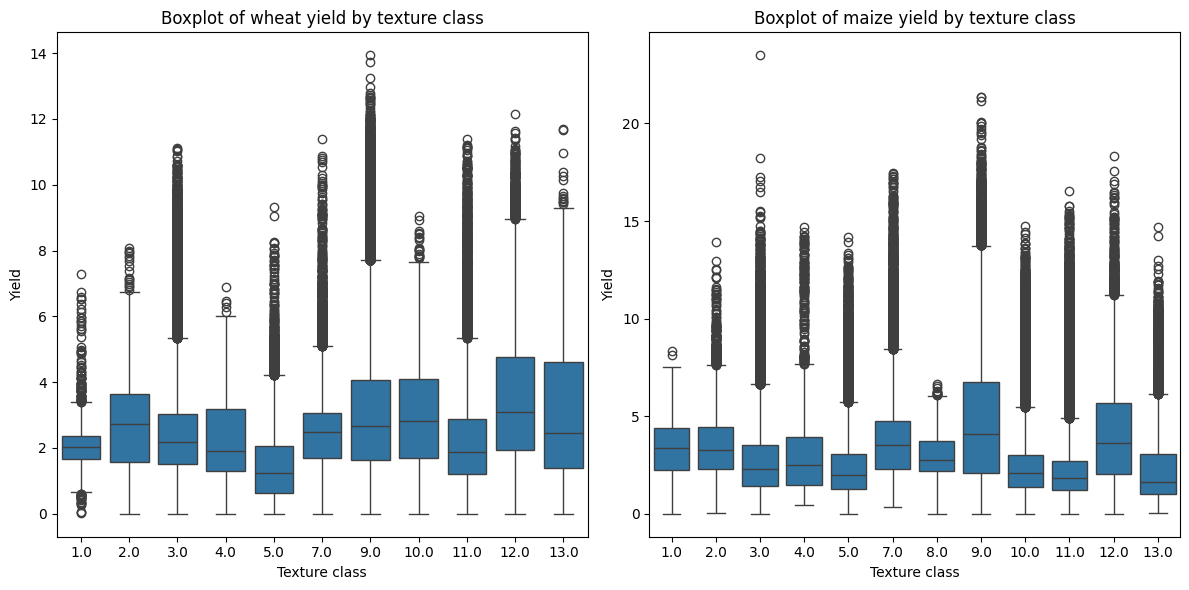

In [30]:
# Create figure with 2x1 subplots
fig, axs = plt.subplots(1, len(df_list), figsize=(12, 6))

for i, df in enumerate(df_list):
    groups = df.groupby('texture_class')['yield'].apply(list)
    F_value, p_value = f_oneway(*groups)
    print(f"{df_names[i]}\nF-value: {F_value}, p-value: {p_value}")

    sns.boxplot(x='texture_class', y='yield', data=df, ax=axs[i])
    axs[i].set_title(f'Boxplot of {df_names[i]} yield by texture class')
    axs[i].set_xlabel('Texture class')
    axs[i].set_ylabel('Yield')

plt.tight_layout()
plt.show()


Seems like there is, we could then use this variable as a not ordered categorical variable in the model.

---

Is there a good way to group latitude and longitude in a single variable and have it correlated with the yield?